#Import Packages

Import required libraries and modules for model training, evaluation, and visualization.
Includes TensorFlow Keras for callbacks, Matplotlib for plotting, NumPy for numerical operations,
and scikit-learn for computing Silhouette Scores. Also imports custom optimisation utilities.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

from sklearn.metrics import silhouette_score


import pickle
import numpy as np

from optimisation import *

#Data Preprocessing

Load log-normalized gene expression counts and corresponding metadata for the CRISPRi_targeted dataset.
Merge and preprocess the data using the custom preprocess_data function to prepare it for modeling.

In [ ]:
logcounts = pd.read_csv("/CRISPRi_targeted_upr_logcounts.csv")

meta_data = pd.read_csv("/meta_CRISPRi_targeted.csv")

# Merge and clean data for modeling
data = preprocess_data(logcounts, meta_data)

Split the preprocessed dataset into training and testing subsets.
Separates features (X) and corresponding labels for target genes and gRNAs
using the custom get_train_test_grna function.

In [ ]:
X_train, X_test, target_gene_train, target_gene_test, gRNA_train, gRNA_test = (
    get_train_test_grna(data))

#Hyperparameter grid search

Perform grid search training of supervised autoencoders across multiple latent dimensions and network architectures.
Evaluates models using Silhouette scores based on both Euclidean and Energy distances, tracking the best-performing
models and configurations for each latent dimension.

The process:
1. Defines a hyperparameter grid for latent dimensions, architecture, activation, optimizer, and dropout.
2. Trains supervised autoencoders using training data.
3. Computes effect thresholds and labels based on distance metrics.
4. Evaluates clustering quality using Silhouette scores.
5. Records the best-performing models and their configurations.

In [ ]:
# Define hyperparameter grid
param_grid = {
    'latent_dim_units': {
        (2, 3, 4, 5): [(256, 64),
                       (128, 32), (256, 64, 16), (256, 32)
                       ],
        (8, 12): [(256, 64),
                  (256, 64, 16)
          ]
        ,
        (18, 27): [(256, 64),
                   (256, 128)
                   ],
        (41, 62): [(256, 128),
                   (512, 128)
                   ],
        (72, 92): [(512, 256),
                       (512, 512)
                       ]
    },
    'activation': ['relu'],
    'optimizer': ['adam'],
    'learning_rate': [1e-4],
    'dropout': [0.0]
}

# Training settings
EPOCHS = 300
BATCH_SIZE = 256
#

# Grid search over hyperparameters
results_history = {}
for y_label in ["gRNA", "target_gene"]:
    results_history[y_label] = {}

    le = LabelEncoder()
    # Fit on training set only (important to avoid data leakage)
    y_train = le.fit_transform(target_gene_train if y_label == "target_gene" else gRNA_train)
    # Transform test set using the same encoder
    y_test = le.transform(target_gene_test if y_label == "target_gene" else gRNA_test)
    num_classes = len(np.unique(y_train))
    best_models_euclidean = {}
    silhouette_score_history_euclidean = []

    best_models_energy = {}
    silhouette_score_history_energy = []
    for latent_group, unit_options in param_grid['latent_dim_units'].items():
        for latent_dim in latent_group:
            # min_losses_dim = [100, 100]
            max_silhouette_score_dim_euclidean = [-1, -1]
            max_silhouette_score_dim_energy = [-1, -1]
            for units in unit_options:
                for activation in param_grid['activation']:
                    for optimizer_name in param_grid['optimizer']:
                        for learning_rate in param_grid['learning_rate']:
                            for dropout in param_grid['dropout']:
                                print(f"Training: latent_dim={latent_dim}, units={units}, "
                                      f"activation={activation}, optimizer={optimizer_name}, "
                                      f"lr={learning_rate}, dropout={dropout}")

                                # Build and train model
                                set_seed()
                                autoencoder, encoder = supervised_autoencoder(
                                    input_dim=X_train.shape[1],
                                    latent_dim=latent_dim,
                                    units=units,
                                    dropout=dropout,
                                    learning_rate=learning_rate,
                                    optimizer=optimizer_name,
                                    activation=activation,
                                    num_classes=num_classes,
                                    y_train=y_train
                                )

                                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                                set_seed()
                                history = autoencoder.fit(
                                    X_train,
                                    {"reconstruction": X_train, "classification": y_train},
                                    validation_split=0.2,
                                    epochs=EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    verbose=1,
                                    callbacks=[early_stop]
                                )

                                # Validation loss
                                val_loss = min(history.history['val_loss'])

                                # Encode train/test data
                                X_test_latent = encoder.predict(X_test)
                                X_train_latent = encoder.predict(X_train)

                                # ---> EUCLIDEAN DISTANCE <---
                                distance_euclidean = compute_distance(X_train_latent, gRNA_train, method="euclidean")
                                threshold_euclidean = compute_threshold_and_plot_hist(distance_euclidean, method="euclidean")

                                # Label effects
                                distance_euclidean["effect"] = np.where(distance_euclidean > threshold_euclidean, "effect", "no effect")
                                effect_dict_euclidean = dict(zip(distance_euclidean.index, distance_euclidean["effect"]))
                                true_labels_effect_test_euclidean = np.array([effect_dict_euclidean.get(g) for g in gRNA_test])
                                true_labels_effect_train_euclidean = np.array([effect_dict_euclidean.get(g) for g in gRNA_train])

                                # Evaluate with Silhouette scores
                                sil_score_test_euclidean = silhouette_score(X_test_latent, true_labels_effect_test_euclidean, metric='euclidean')
                                sil_score_train_euclidean = silhouette_score(X_train_latent, true_labels_effect_train_euclidean, metric='euclidean')
                                print("Test set Silhouette score:", sil_score_test_euclidean)
                                print("Train set Silhouette score:", sil_score_train_euclidean)

                                # Keep best model per latent_dim
                                if sil_score_test_euclidean > max_silhouette_score_dim_euclidean[0]:
                                    max_silhouette_score_dim_euclidean = [sil_score_test_euclidean, sil_score_train_euclidean]
                                    best_models_euclidean[latent_dim] = {
                                        'autoencoder': autoencoder,
                                        'encoder': encoder,
                                        'history': history,
                                        'config': {
                                            'units': units,
                                            'activation': activation,
                                            'optimizer': optimizer_name,
                                            'learning_rate': learning_rate,
                                            'dropout': dropout
                                        }
                                    }
                                # ---> ENERGY DISTANCE <---
                                distance_energy = compute_distance(X_train_latent, gRNA_train, method="energy")
                                threshold_energy = compute_threshold_and_plot_hist(distance_energy, method="energy")

                                # Label effects
                                distance_energy["effect"] = np.where(distance_energy > threshold_energy, "effect", "no effect")
                                effect_dict_energy = dict(zip(distance_energy.index, distance_energy["effect"]))
                                true_labels_effect_test_energy = np.array([effect_dict_energy.get(g) for g in gRNA_test])
                                true_labels_effect_train_energy = np.array([effect_dict_energy.get(g) for g in gRNA_train])

                                # Evaluate with Silhouette scores
                                sil_score_test_energy = silhouette_score(X_test_latent, true_labels_effect_test_energy, metric='euclidean')
                                sil_score_train_energy = silhouette_score(X_train_latent, true_labels_effect_train_energy, metric='euclidean')
                                print("Test set Silhouette score:", sil_score_test_energy)
                                print("Train set Silhouette score:", sil_score_train_energy)

                                # Keep best model per latent_dim
                                if sil_score_test_energy > max_silhouette_score_dim_energy[0]:
                                    max_silhouette_score_dim_energy = [sil_score_test_energy, sil_score_train_energy]
                                    best_models_energy[latent_dim] = {
                                        'autoencoder': autoencoder,
                                        'encoder': encoder,
                                        'history': history,
                                        'config': {
                                            'units': units,
                                            'activation': activation,
                                            'optimizer': optimizer_name,
                                            'learning_rate': learning_rate,
                                            'dropout': dropout
                                        }
                                    }

            # Store silhouette results
            silhouette_score_history_euclidean.append([max_silhouette_score_dim_euclidean[0], max_silhouette_score_dim_euclidean[1]])
            silhouette_score_history_energy.append([max_silhouette_score_dim_energy[0], max_silhouette_score_dim_energy[1]])

    results_history[y_label]["euclidean"] = {
        "silhouette_score_history": silhouette_score_history_euclidean,
        "best_models": best_models_euclidean
    }
    results_history[y_label]["energy"] = {
        "silhouette_score_history": silhouette_score_history_energy,
        "best_models": best_models_energy
    }

Streaming output truncated to the last 5000 lines.
Epoch 25/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - classification_accuracy: 0.0889 - classification_loss: 3.3371 - loss: 3.7796 - reconstruction_loss: 0.8847 - val_classification_accuracy: 0.0617 - val_classification_loss: 3.4330 - val_loss: 3.8965 - val_reconstruction_loss: 0.9572
Epoch 26/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - classification_accuracy: 0.0901 - classification_loss: 3.3290 - loss: 3.7694 - reconstruction_loss: 0.8804 - val_classification_accuracy: 0.0645 - val_classification_loss: 3.4280 - val_loss: 3.8889 - val_reconstruction_loss: 0.9529
Epoch 27/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - classification_accuracy: 0.0901 - classification_loss: 3.3209 - loss: 3.7594 - reconstruction_loss: 0.8766 - val_classification_accuracy: 0.0664 - val_classification_loss: 3.4230 - val_loss: 3.8814 - val_reconstruction_loss: 0.9490
Epoch 28/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - classification_accuracy: 0.0895 -

Visualize Silhouette Score trends across latent dimensions for different distance metrics (Euclidean and Energy)
and label types (gRNA and target_gene). The plot compares training and test set Silhouette Scores to evaluate
representation quality across model configurations.

In [ ]:
plt.rcParams.update({
    'font.size': 16,            # Base font size
    'axes.titlesize': 18,       # Title font size
    'axes.labelsize': 17,       # Axis label font size
    'xtick.labelsize': 16,      # X-tick label size
    'ytick.labelsize': 16,      # Y-tick label size
    'legend.fontsize': 16,      # Legend font size
})

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

latent_dim = [int(x) for group in param_grid['latent_dim_units'].keys() for x in group]

plot_idx = 0
for y_label in ["gRNA", "target_gene"]:
    for method in ["euclidean", "energy"]:
        ax = axes[plot_idx]
        plot_idx += 1

        sil_hist = np.array(results_history[y_label][method]["silhouette_score_history"])

        if len(sil_hist) == 0:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
            continue

        ax.plot(latent_dim, sil_hist[:, 0], label="Test Set", color="red", marker="o")
        ax.plot(latent_dim, sil_hist[:, 1], label="Train Set", color="blue", marker="o")

        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax.set_title(f"{y_label} — {method.capitalize()} distance")
        ax.set_xlabel("Latent Dimension")
        ax.set_ylabel("Silhouette Score")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.savefig("silhouette_scores_CRISPRi_targeted.pdf")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Find threshold

Load and evaluate the best-performing model for a specific latent dimension and method.
Encode data using the trained encoder, compute pairwise distances, determine an optimal
threshold for distinguishing effects, and label each gRNA as 'effect' or 'no effect'.

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


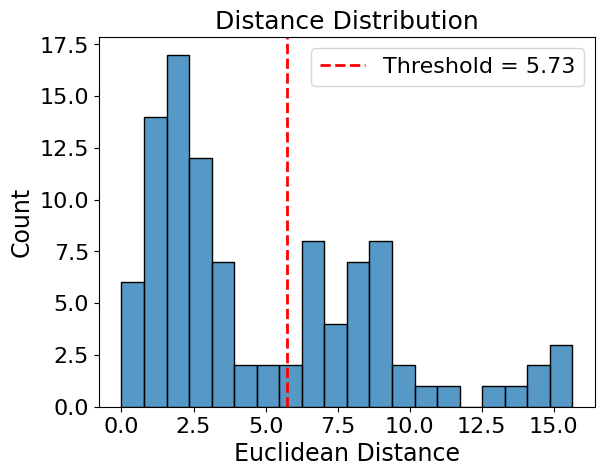

,count
effect,
no effect,60
effect,40


In [ ]:
# Load best model for selected latent dimension
dimension = 12
method = "euclidean"
y_label = "target_gene"
best_models = results_history[y_label][method]["best_models"]
best_model = best_models[dimension]
best_autoencoder = best_model['autoencoder']
best_encoder = best_model['encoder']

# Encode train/test data using best encoder
X_test_latent = best_encoder.predict(X_test)
X_train_latent = best_encoder.predict(X_train)

# Compute distances from control and find optimal threshold
distance = compute_distance(X_train_latent, gRNA_train, method=method)
threshold = compute_threshold_and_plot_hist(distance, plot=True, method=method, log1p=False)

# Label each gRNA as 'effect' or 'no effect'
results = distance
results["effect"] = np.where(results > threshold, "effect", "no effect")
results["effect"].value_counts()

Assign effect labels to gRNAs based on computed distance thresholds, integrate these labels
into the dataset, and evaluate the separation quality of the latent space using Silhouette Scores.

In [ ]:
# Map each gRNA to its effect label
effect_dict = dict(zip(results.index, results["effect"]))

# Create label arrays for train/test sets
true_labels_effect_test = np.array([effect_dict.get(g) for g in gRNA_test])
true_labels_effect_train = np.array([effect_dict.get(g) for g in gRNA_train])

# Add effect labels back to full dataset
data["effect"] = data["gRNA_simplified"].map(effect_dict)

# Evaluate latent space separation with Silhouette scores
sil_score_test = silhouette_score(X_test_latent, true_labels_effect_test, metric='euclidean')
print("Test set Silhouette score:", sil_score_test)

sil_score_train = silhouette_score(X_train_latent, true_labels_effect_train, metric='euclidean')
print("Train set Silhouette score:", sil_score_train)

Test set Silhouette score: 0.21458088
Train set Silhouette score: 0.21872635


Identify genes whose associated gRNAs exhibit heterogeneous effects — i.e., cases where
both 'effect' and 'no effect' classifications occur within the same target gene group.

In [ ]:
# Keep genes where gRNAs show mixed effects (both 'effect' and 'no effect')
mask = data.groupby("target_gene")["effect"].transform("nunique") > 1

# Filter and show unique gRNA–gene–effect combinations
filtered = data.loc[mask, ["gRNA_simplified", "target_gene", "effect"]]
filtered.drop_duplicates()

,gRNA_simplified,target_gene,effect
AAACCTGCAGCTGCAC.1,sgRNA--SRP68-3,SRP68,no effect
AAACGGGTCCGGCACA.1,sgRNA--CARS-2,CARS,effect
AAAGATGCAATGAATG.1,sgRNA--CARS-3,CARS,no effect
AAAGATGGTCCAACTA.1,sgRNA--SRP68-1,SRP68,effect
AAATGCCCATGGTTGT.1,sgRNA--DDOST-2,DDOST,effect
AACACGTTCTGCTTGC.1,sgRNA--DDOST-3,DDOST,no effect
AACCATGCAATAGAGT.1,sgRNA--CARS-1,CARS,effect
AAGACCTGTAAATGAC.1,sgRNA--DDOST-1,DDOST,no effect
AATCCAGAGACAGACC.1,sgRNA--SRP68-6,SRP68,no effect


#Save results for future analyses

Generate and save effect labeling results for all latent dimensions, distance metrics,
and label configurations. Each gRNA–gene pair is assigned an 'effect' or 'no effect' label
based on model-inferred thresholds computed from latent representations.

The resulting DataFrame includes metadata (dimension, method, y_label) and
is saved for downstream comparative analyses.

In [ ]:
effect_results_by_dim = pd.DataFrame(
    columns=["dimension", "method", "y_label", "target_gene", "gRNA_simplified", "effect_label"]
)

methods = ["euclidean", "energy"]
y_labels = ["target_gene", "gRNA"]

for method in methods:
    for y_label in y_labels:
        for dimension in latent_dim:

            best_models = results_history[y_label][method]["best_models"]
            best_model = best_models[dimension]
            best_encoder = best_model['encoder']

            # Encode train/test data
            X_train_latent = best_encoder.predict(X_train)
            X_test_latent = best_encoder.predict(X_test)

            # Compute distances and threshold
            distance = compute_distance(X_train_latent, gRNA_train, method=method)
            threshold = compute_threshold_and_plot_hist(distance, plot=False, method=method, log1p=False)

            # Label gRNAs
            results = distance.copy()
            results["effect"] = np.where(results > threshold, "effect", "no effect")
            effect_dict = dict(zip(results.index, results["effect"]))
            data_copy = data.copy()
            data_copy["effect"] = data_copy["gRNA_simplified"].map(effect_dict)

            df = data_copy[["target_gene", "gRNA_simplified", "effect"]].drop_duplicates()
            df["effect_label"] = (df["effect"] == "effect").astype(int)

            # Add metadata columns
            df["dimension"] = dimension
            df["method"] = method
            df["y_label"] = y_label

            # Append properly
            effect_results_by_dim = pd.concat([effect_results_by_dim, df], ignore_index=True)

# Save to CSV
effect_results_by_dim.to_csv("CRISPRi_targeted_effects.csv", index=False)

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Clean and save a simplified version of the results_history dictionary containing only
the hyperparameter configurations of the best models and their associated Silhouette scores.
This ensures compatibility for later use and avoids storing full model objects.

In [ ]:
results_history_configs = {}

for y_label, method_dict in results_history.items():
    results_history_configs[y_label] = {}
    for method, info in method_dict.items():
        if "best_models" in info:
            # Convert silhouette scores to standard Python floats
            sil_scores = info.get("silhouette_score_history", [])
            sil_scores_clean = []
            for pair in sil_scores:
                if isinstance(pair, (list, tuple, np.ndarray)):
                    sil_scores_clean.append([float(x) if x is not None else None for x in pair])
                else:
                    sil_scores_clean.append(float(pair) if pair is not None else None)

            results_history_configs[y_label][method] = {
                "silhouette_score_history": sil_scores_clean,
                "best_models": {}
            }

            for latent_dim, model_info in info["best_models"].items():
                results_history_configs[y_label][method]["best_models"][latent_dim] = {
                    "config": model_info.get("config", {})
                }

# Save cleaned dictionary to a pickle file
with open("results_history_configs_CRISPRi_trageted.pkl", "wb") as f:
    pickle.dump(results_history_configs, f)